# Building Workflows and Agents with LangGraph

## What are Agentic Systems?

Agentic systems are AI-driven systems that leverage large language models (LLMs) and tools to accomplish tasks. 
They can be broadly categorized into two types: 
- **Workflows** and **Agents**, each with distinct architectural designs.

### 1. Workflows
- **Definition**: Systems where LLMs and tools follow predefined, structured code paths to complete tasks.
- **Characteristics**:
  - Operate with fixed sequences or rules.
  - Ideal for predictable, repeatable tasks.
  - Less flexible but easier to control and debug.
- **Example Use Case**: A customer support bot that follows a scripted decision tree to resolve common queries.

### 2. Agents
- **Definition**: Systems where LLMs dynamically control their processes and tool usage to achieve goals.
- **Characteristics**:
  - Fully or partially autonomous, adapting to task requirements in real time.
  - Use reasoning to decide which tools to call and when.
  - More flexible but complex to design and manage.
- **Example Use Case**: A research assistant that autonomously searches, synthesizes, and summarizes information from multiple sources.

### Key Architectural Distinction
- **Workflows**: Predefined paths with explicit instructions.
- **Agents**: Dynamic decision-making with LLM-driven control.

## When to Use What
Agents are well suited to open-ended problems where it's difficult to predict the exact steps needed in advance.

Workflows are often appropriate when the control flow can easily be defined in advance.

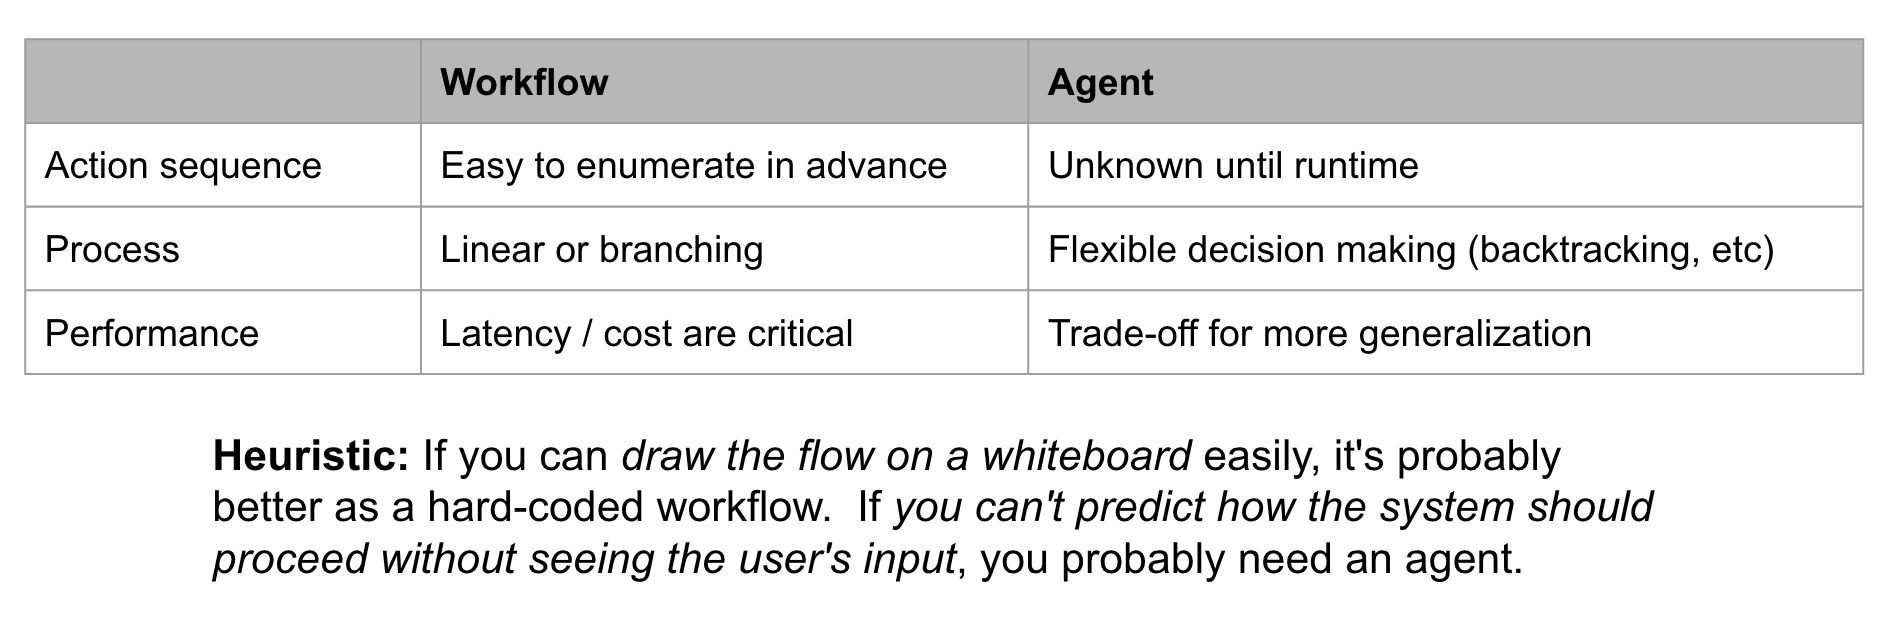



## LangGraph for Building Workflows and Agents
- **What is LangGraph?**
  - A framework for creating stateful, graph-based workflows and agents.
  - Enables modular design of agentic systems by representing tasks as nodes and transitions as edges.
  - Supports both predefined workflows and dynamic agentic behavior.
- **Why Use LangGraph?**
  - Simplifies orchestration of LLMs and tools.
  - Provides state management for long-running or multi-step processes.
  - Flexible for both structured workflows and autonomous agents.
- **Key Components**:
  - **Nodes**: Represent tasks or tools (e.g., LLM calls, API queries).
  - **Edges**: Define transitions between tasks, either fixed (workflows) or conditional (agents).
  - **State**: Tracks progress and context across the graph.
- **Example**:
  - A workflow node might execute a predefined API call to fetch data.
  - An agent node might decide which API to call based on prior context.


## Practical Applications
- **Workflows**: Automating business processes like form processing or data pipelines.
- **Agents**: Building intelligent systems like virtual assistants or research bots that adapt to user needs.

In [22]:
from dotenv import load_dotenv
load_dotenv()

True

In [23]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4o-mini", temperature=0)

llm.invoke("Hello, how are you?")

AIMessage(content="Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 13, 'total_tokens': 42, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C1VA3G8ZSp3ocuisVUjwJX73Dy0qd', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--0bd28205-1ced-461d-8f28-777ea9148583-0', usage_metadata={'input_tokens': 13, 'output_tokens': 29, 'total_tokens': 42, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

# Building Blocks, Workflows, and Agents

This section explores common patterns for agentic systems in production, starting with the foundational building block
 - the augmented LLM
 - and progressing to more complex structures like compositional workflows and autonomous agents.

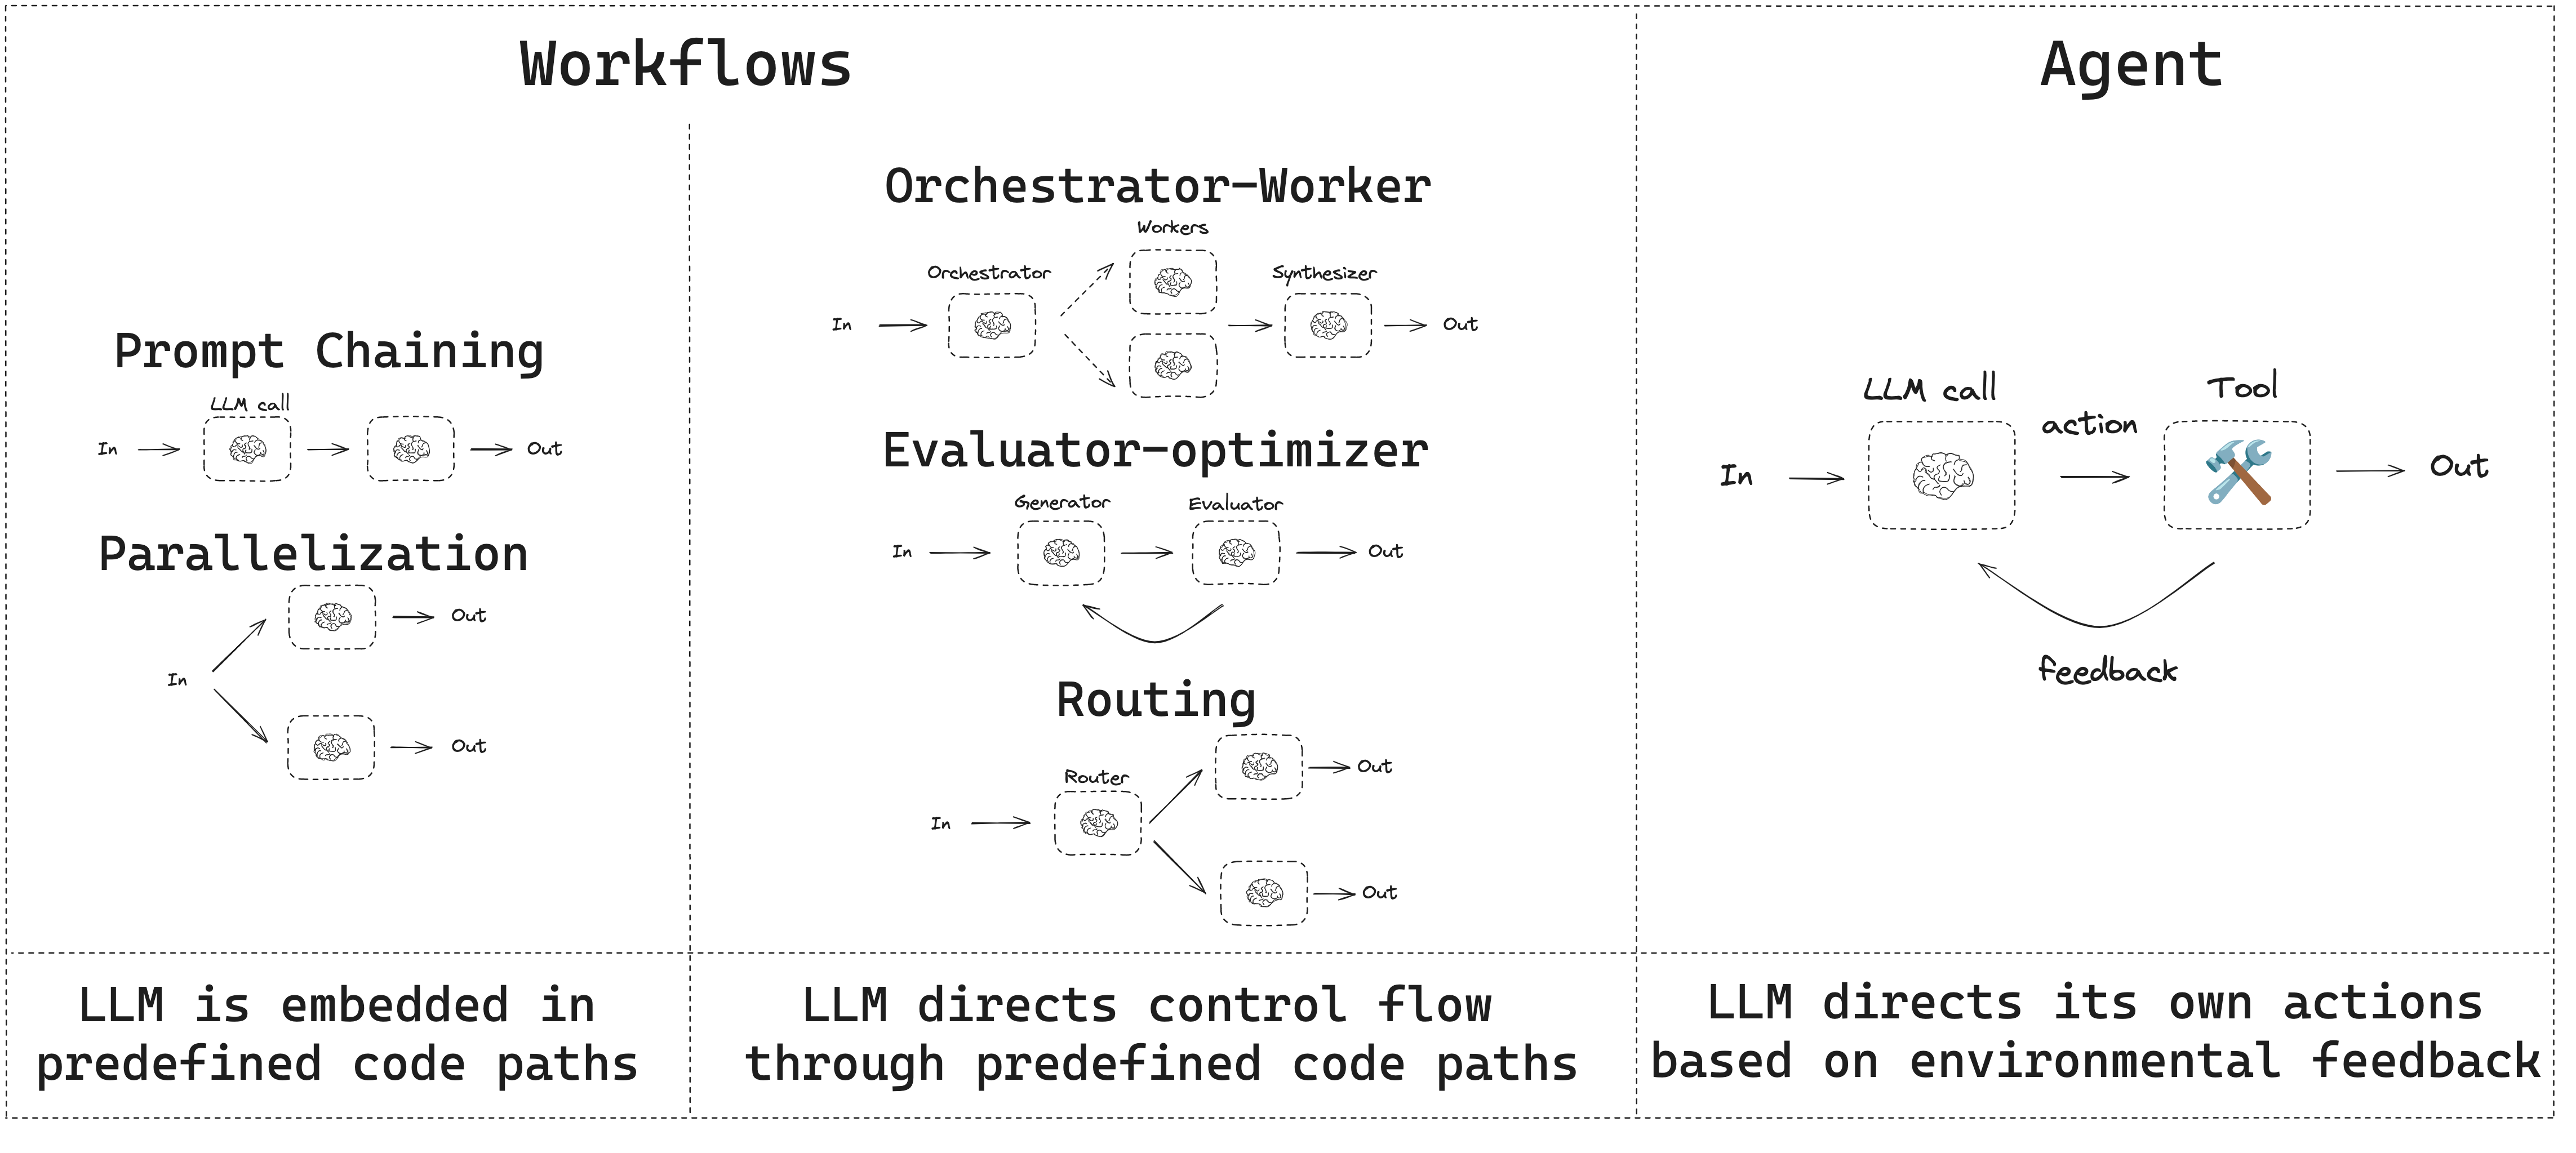

## Building Block: The Augmented LLM

LLM have augmentations that support building workflows and agents. These include 
- **structured outputs** 

- **tool calling**

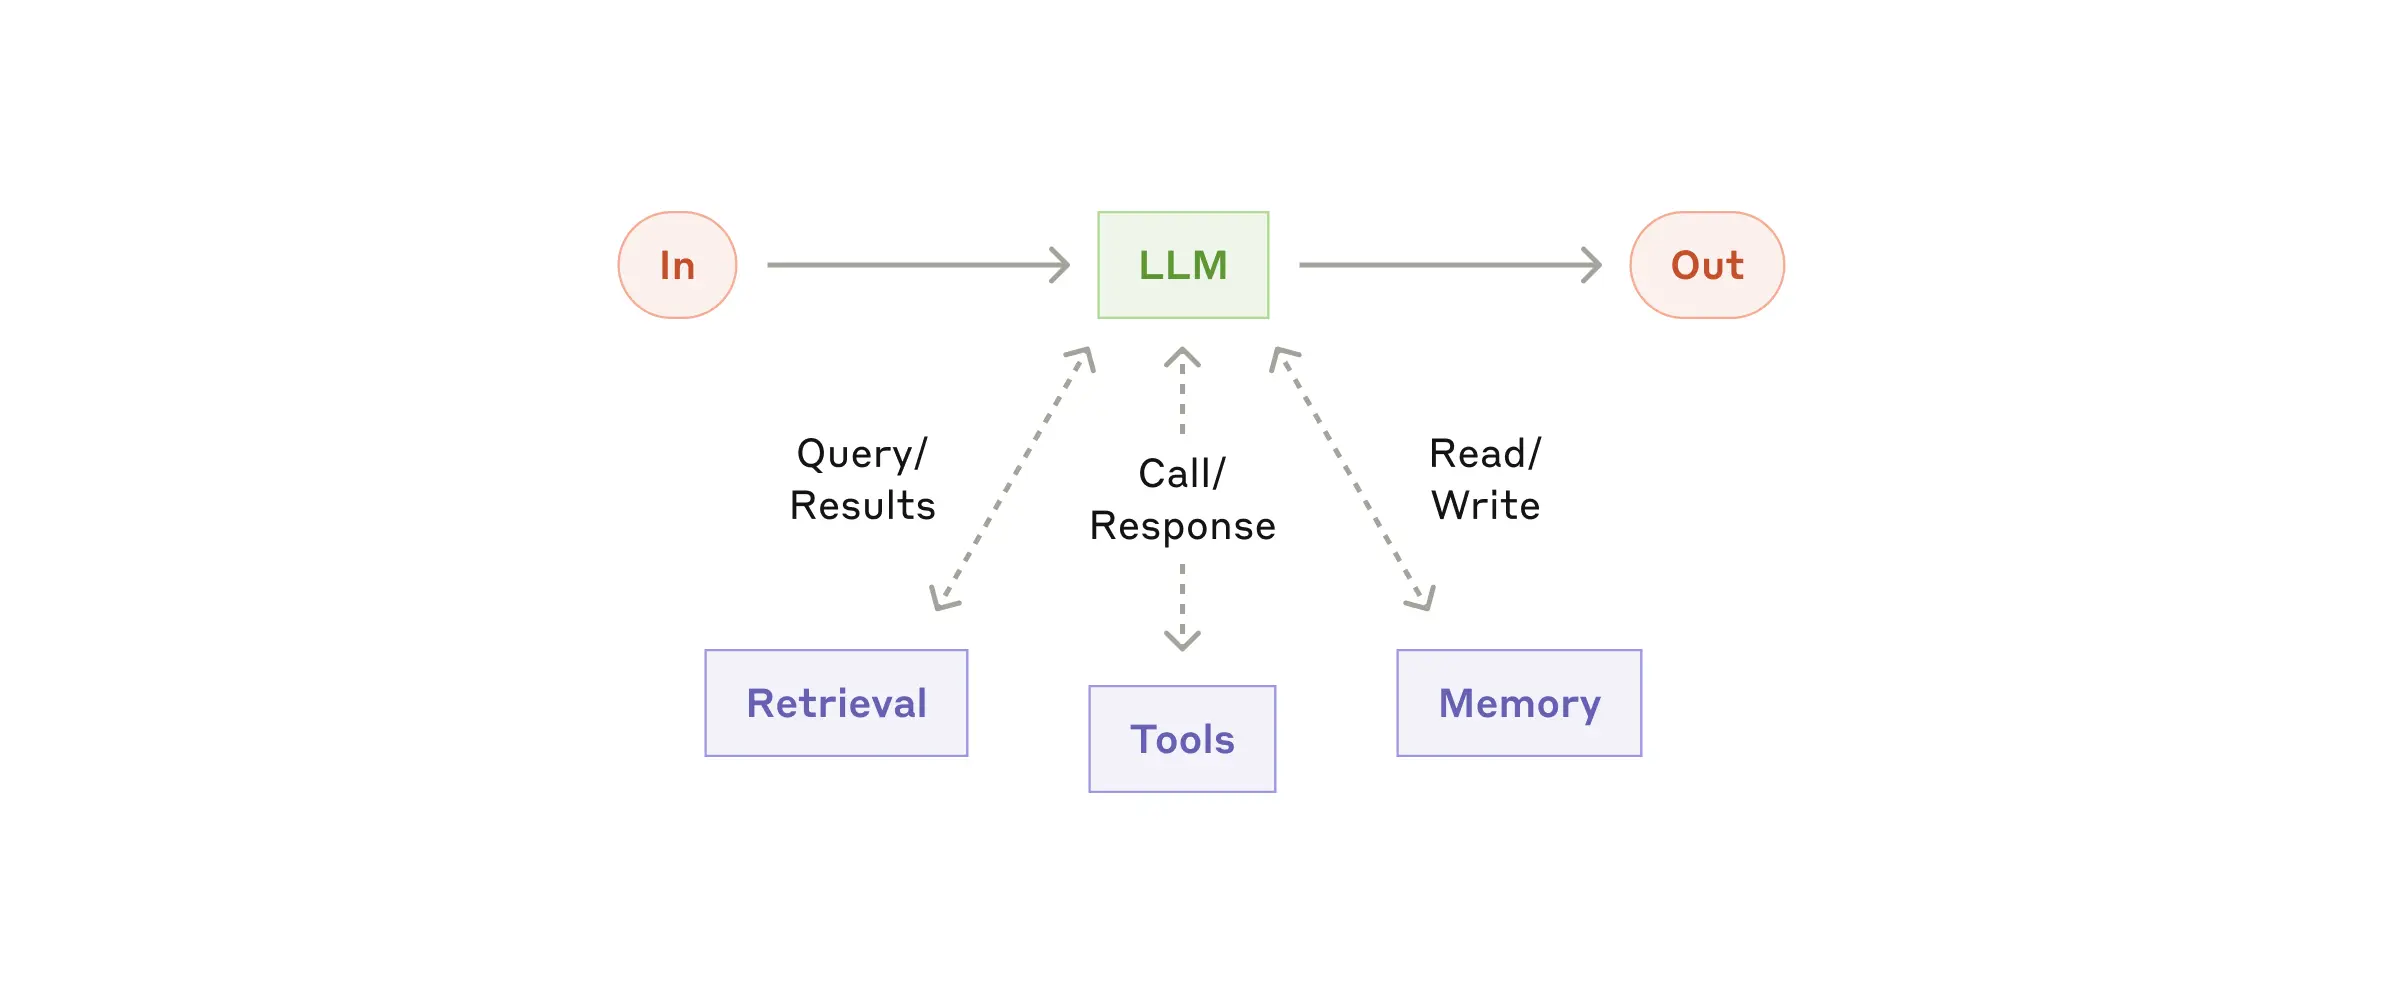

### 1. Structured output

In [24]:
#Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    query: str = Field(description="The search query")
    justification: str = Field(description="Why is this the best search query?")

# Augment the llm with the schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the structured llm
structured_llm.invoke("I want to know the current price of macbook m4 pro in Kenya")

SearchQuery(query='current price of MacBook M4 Pro in Kenya', justification="This search query is specific and directly addresses the user's request for the current price of a specific product (MacBook M4 Pro) in a specific location (Kenya), ensuring relevant and accurate results.")

### 2. Tool calling

In [25]:
#Define a tool
from langchain_core.tools import tool

@tool
def get_current_price(product: str, location: str) -> str:
    """
    Returns the current price of a product in a specific location.
    """
    return f"The current price of {product} in {location} is $100."

@tool
def get_current_weather(location: str) -> str:
    """
    Returns the current weather in a specific location.
    """
    return f"The current weather in {location} is sunny."

#Bind the tools to the llm
llm_with_tools = llm.bind_tools(tools=[get_current_price, get_current_weather])

#Invoke the llm with query that will trigger the tools
response = llm_with_tools.invoke("I want to know the current price of macbook m4 pro in Kenya")

response.tool_calls

[{'name': 'get_current_price',
  'args': {'product': 'macbook m4 pro', 'location': 'Kenya'},
  'id': 'call_gYniHR6DZCBlRGJZSFTyqPQm',
  'type': 'tool_call'}]

# Workflow: Prompt chaining
Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. 
You can add programmatic checks (see "gate" in the diagram below) on any intermediate steps to ensure that the process is still on track.


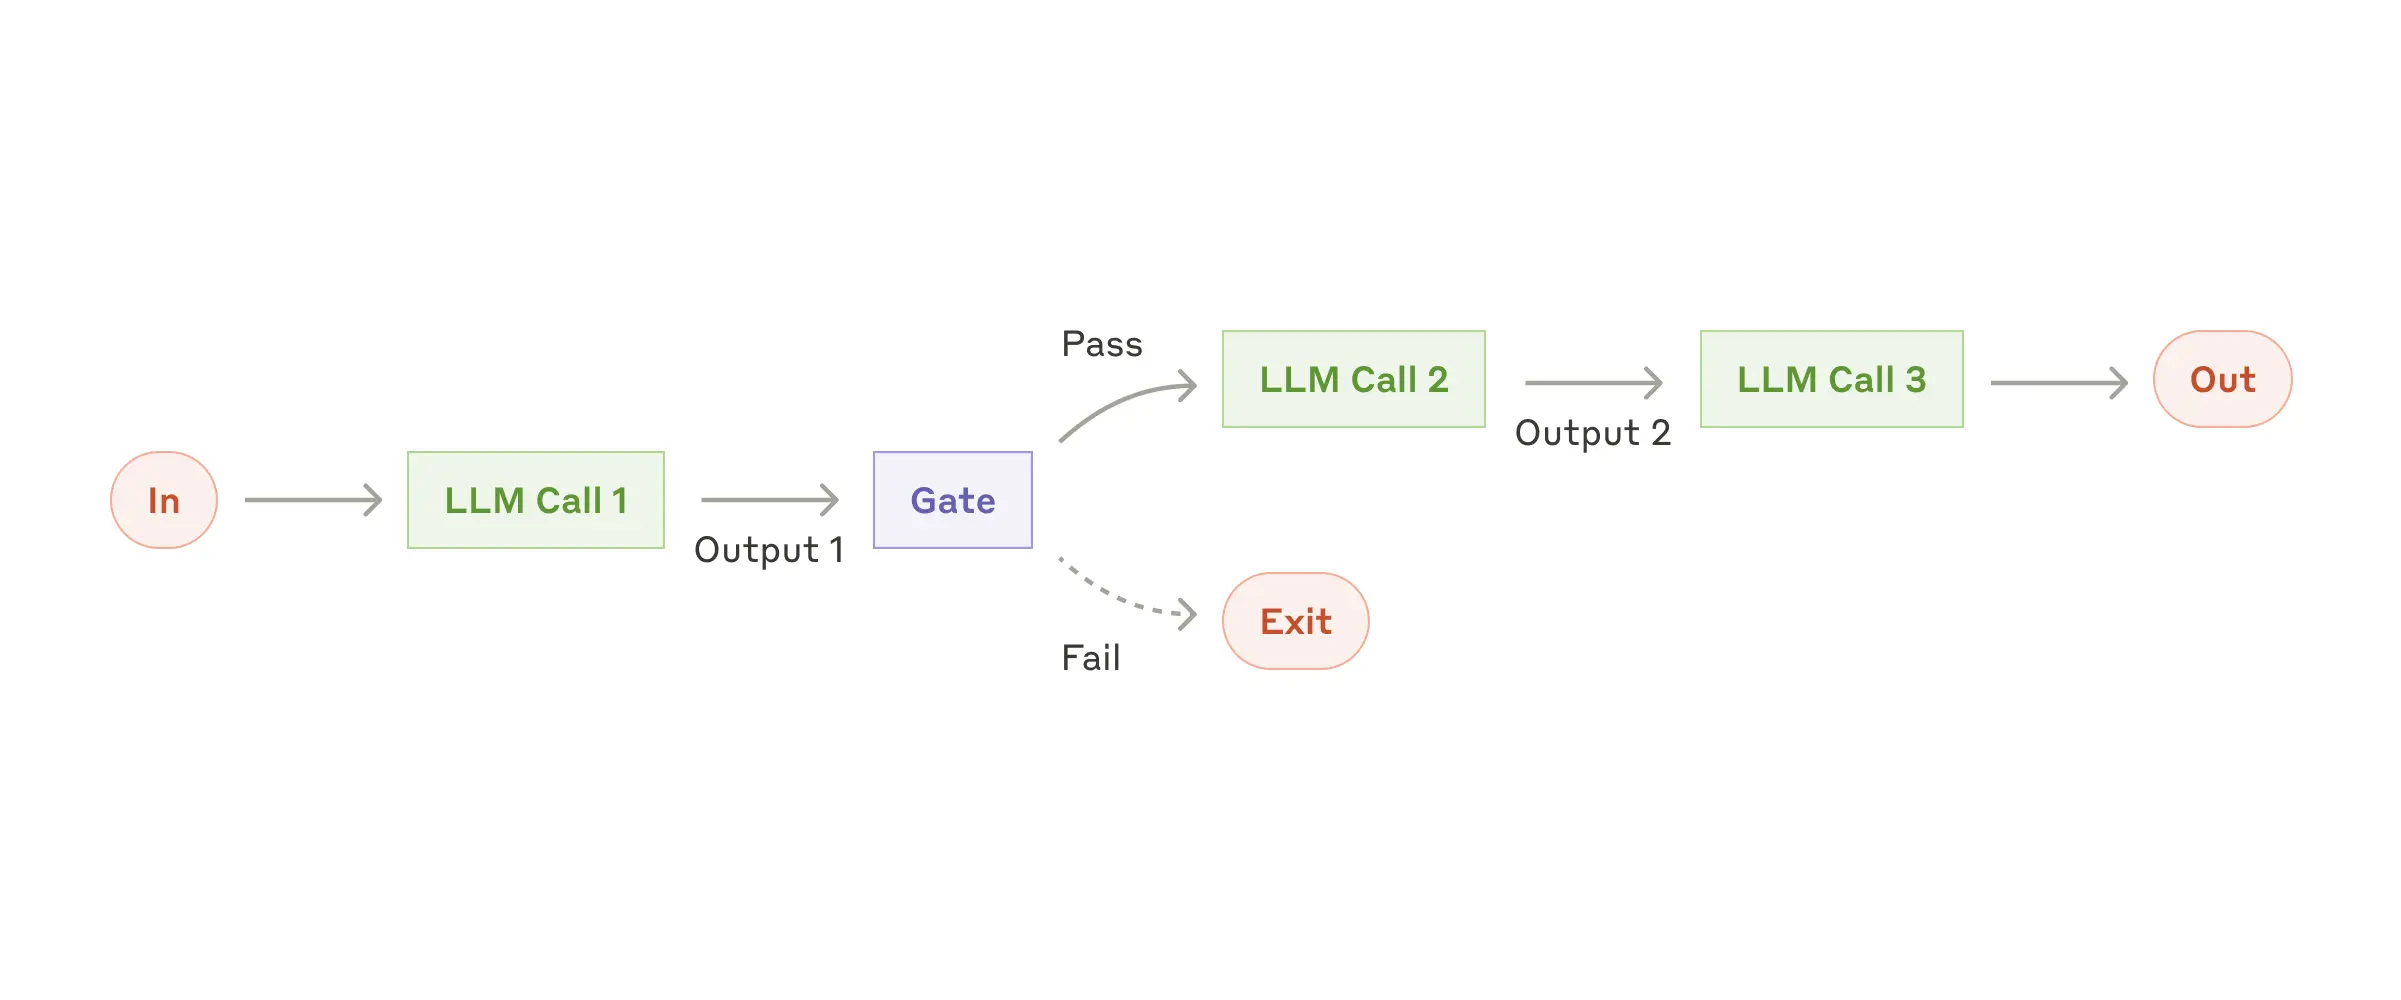

**When to use this workflow:** This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.


In [26]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState
from pydantic import BaseModel, Field
from typing import TypedDict
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4o-mini")

#Define the state
class AgentState(MessagesState):
    """State for the agent"""
    classification: str 
    
#Define the AnalyzedInput class
class AnalyzedInput(BaseModel):
    """Analyzed input"""
    classification: str = Field(description="Classification of the input. Can be get_product_price or get_weather_info")
    reason: str = Field(description="Reason for the classification")
    
# Define the analyze_user_input function
def analyze_user_input(state: AgentState) -> AgentState:
    """Analyze the user input"""
    user_query = state['messages'][-1].content
    
    structured_llm = llm.with_structured_output(AnalyzedInput)
    
    system_instruction = """You are a helpful assistant that can analyze user input and classify it into one of two categories: get_product_price or get_weather_info."""
    
    messages = [
        {"role": "system", "content": system_instruction},
        {"role": "user", "content": user_query}
    ]
    
    response = structured_llm.invoke(messages)
    
    return {"classification": response.classification}

# Define the get_product_price function
def get_product_price(state: AgentState) -> AgentState:
    """Get the product price"""
    
    system_instruction = """You are a helpful assistant that can get the product price."""
    
    messages = [
        {"role": "system", "content": system_instruction},
        {"role": "user", "content": state['messages'][-1].content}
    ]
    
    response = llm.invoke(messages)
    
    return {"messages": [response]}

# Define the get_weather_info function
def get_weather_info(state: AgentState) -> AgentState:
    """Get the weather info"""
    
    system_instruction = """You are a helpful assistant that can get the weather info."""
    
    messages = [
        {"role": "system", "content": system_instruction},
        {"role": "user", "content": state['messages'][-1].content}
    ]
    
    response = llm.invoke(messages)
    
    return {"messages": [response]}

#def translate to swahili function
def translate_to_swahili(state: AgentState) -> AgentState:
    """Translate the user input to swahili"""
    
    system_instruction = """You are a helpful assistant that can translate user input to swahili."""
    
    messages = [
        {"role": "system", "content": system_instruction},
        {"role": "user", "content": state['messages'][-1].content}
    ]
    
    response = llm.invoke(messages)
    
    return {"messages": [response]}

# Define the route_user_query function
def route_user_query(state: AgentState) -> AgentState:
    """Route the user query to the appropriate node"""
    
    if state['classification'] == "get_product_price":
        return "get_product_price"
    
    return "get_weather_info"
   

# Define the graph
graph_builder = StateGraph(AgentState)

# Add nodes
graph_builder.add_node("analyze_user_input", analyze_user_input)
graph_builder.add_node("get_product_price", get_product_price)
graph_builder.add_node("get_weather_info", get_weather_info)
graph_builder.add_node("translate_to_swahili", translate_to_swahili)

# Add edges
graph_builder.add_edge(START, "analyze_user_input")
graph_builder.add_conditional_edges("analyze_user_input", route_user_query, {"get_product_price": "get_product_price", "get_weather_info": "get_weather_info"})
graph_builder.add_edge("get_product_price", END)
graph_builder.add_edge("get_weather_info", "translate_to_swahili")
graph_builder.add_edge("translate_to_swahili", END)

# Compile the graph
graph = graph_builder.compile()

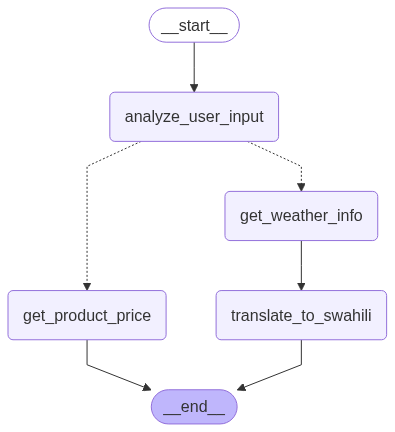

In [27]:
from IPython.display import Image
# Show workflow
display(Image(graph.get_graph().draw_mermaid_png()))


In [28]:
result = graph.invoke({"messages": [{"role": "user", "content": "What is the price of a product?"}]})
print(result)

{'messages': [HumanMessage(content='What is the price of a product?', additional_kwargs={}, response_metadata={}, id='f99be62b-b1bf-4514-a90b-ad9c1f776df3'), AIMessage(content="I would need to know the name or type of product you're asking about in order to provide you with the price. Could you please specify the product?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 31, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-C1VAA6b84qXJkrUkDFMUMnEa1cBiD', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c7c8e7b0-ea1d-41d2-88df-3ad6ec9c1bb0-0', usage_metadata={'input_tokens': 31, 'output_tokens': 30, 'total_tokens': 61, 'inpu

In [29]:
result['messages'][-1].content

"I would need to know the name or type of product you're asking about in order to provide you with the price. Could you please specify the product?"

# Workflow: Routing
Routing classifies an input and directs it to a specialized followup task. 
This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

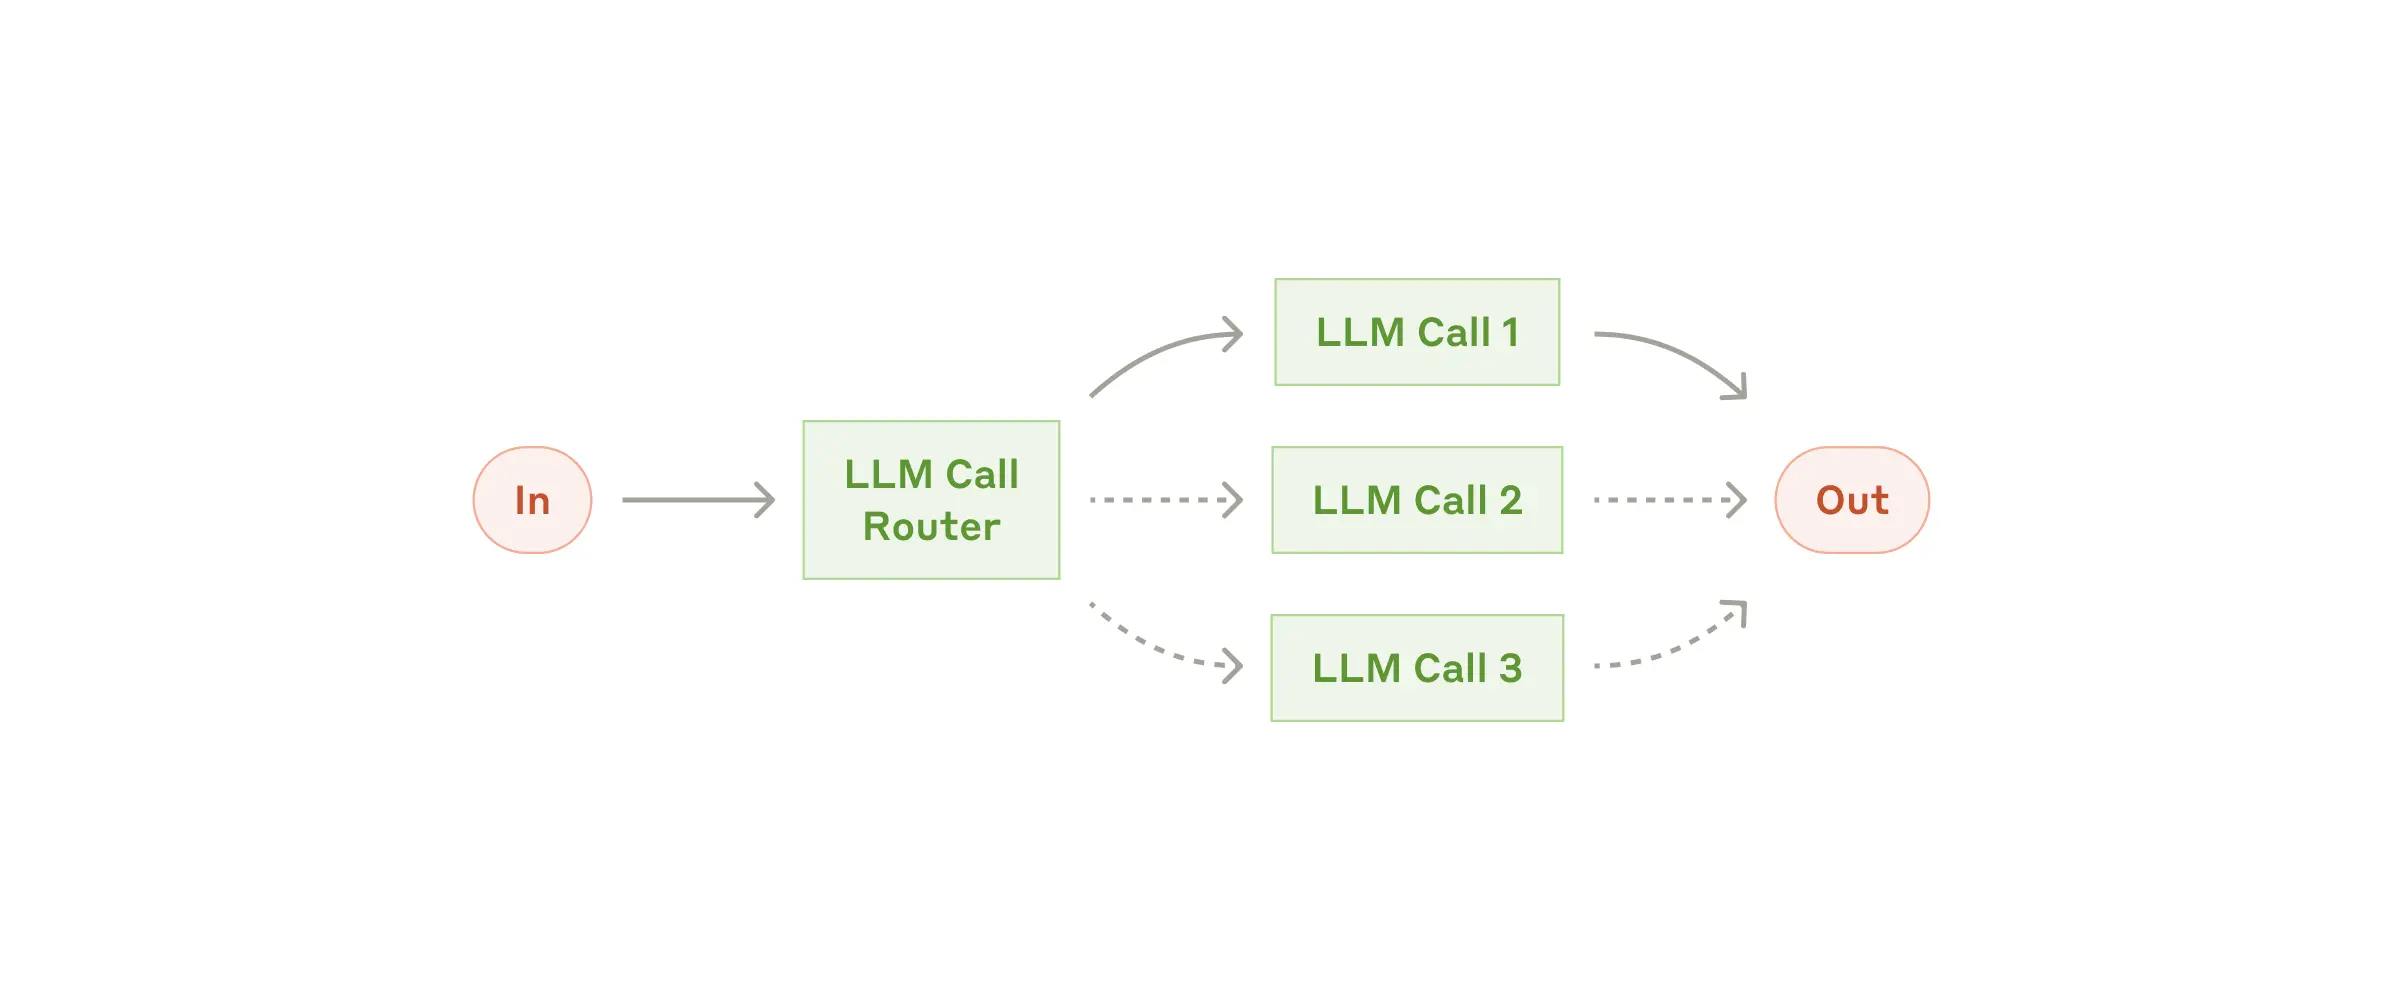

### When to use this workflow:
Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

### Examples where routing is useful:

Directing different types of customer service queries (general questions, refund requests, technical support) into different downstream processes, prompts, and tools.



# Workflow: Parallelization

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically or using an LLM. This workflow, parallelization, manifests in two key variations:

- Sectioning: Breaking a task into independent subtasks run in parallel.
- Voting: Running the same task multiple times to get diverse outputs.

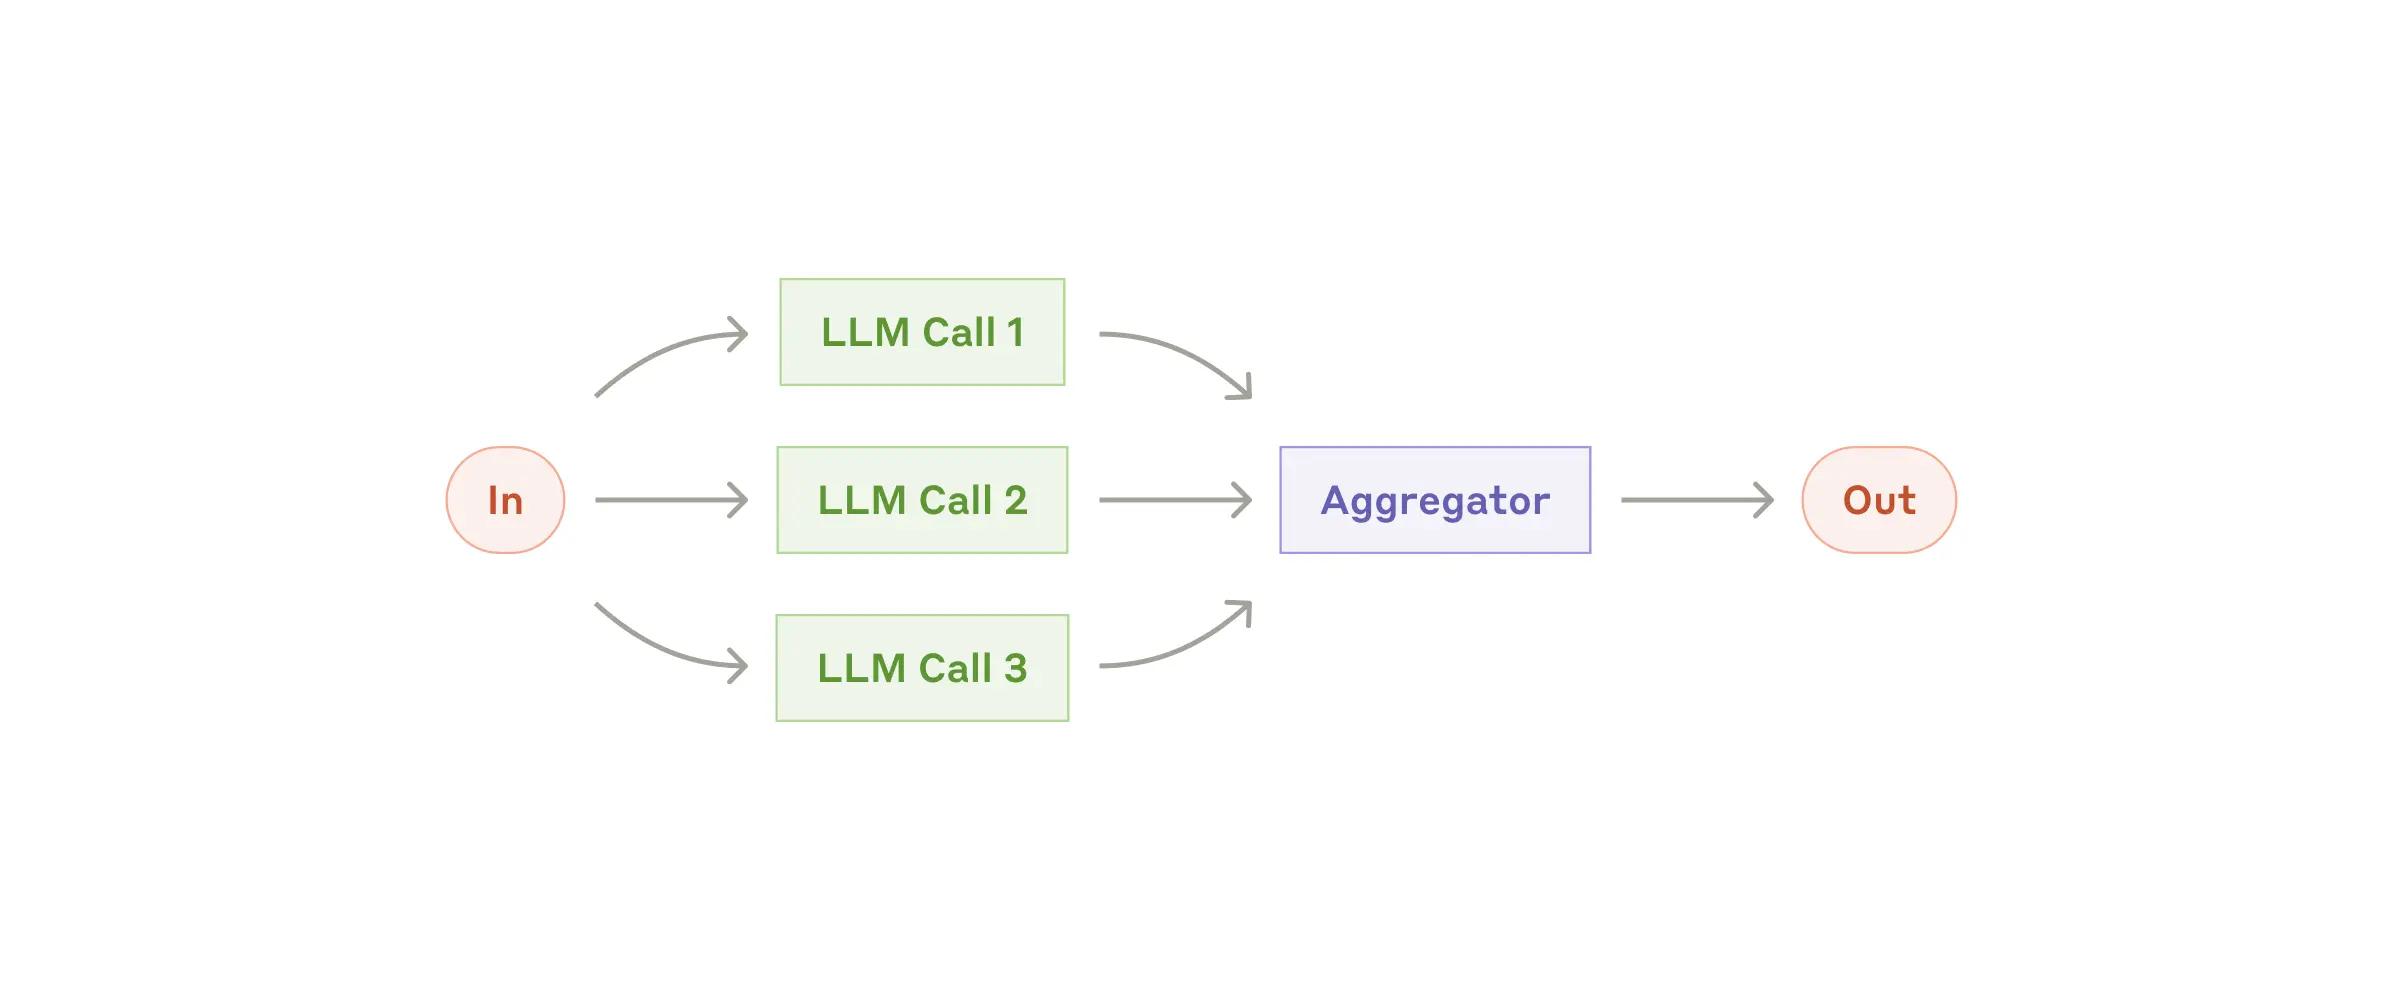


### When to use this workflow:
Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

### Examples where parallelization is useful:
- **Sectioning**:
    - Implementing guardrails where one model instance processes user queries while another screens them for inappropriate content or requests. This tends to perform better than having the same LLM call handle both guardrails and the core response.

- **Voting**:
    - Evaluating whether a given piece of content is inappropriate, with multiple prompts evaluating different aspects or requiring different vote thresholds to balance false positives and negatives.

### Example of parallelization: 


In [30]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState
from pydantic import BaseModel, Field
from typing import TypedDict
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4o-mini")

# Define the state
class AgentState(MessagesState):
    """State for the agent"""
    joke: str
    poem: str
    story: str
    combined_output: str
    
    
    
def generate_joke(state: AgentState) -> AgentState:
    """Generate a joke"""
    
    user_query = state['messages'][-1].content
    
    system_instruction = """You are a helpful assistant that can generate a joke."""
    
    messages = [
        {"role": "system", "content": system_instruction},
        {"role": "user", "content": user_query}
    ]
    
    response = llm.invoke(messages)
    
    return {"joke": response.content}


def generate_poem(state: AgentState) -> AgentState:
    """Generate a poem"""
    
    user_query = state['messages'][-1].content
    
    system_instruction = """You are a helpful assistant that can generate a poem."""
    
    messages = [
        {"role": "system", "content": system_instruction},
        {"role": "user", "content": user_query}
    ]
    
    response = llm.invoke(messages)
    
    return {"poem": response.content}


def generate_story(state: AgentState) -> AgentState:
    """Generate a story"""
    
    user_query = state['messages'][-1].content
    
    system_instruction = """You are a helpful assistant that can generate a story."""
    
    messages = [
        {"role": "system", "content": system_instruction},
        {"role": "user", "content": user_query}
    ]
    
    response = llm.invoke(messages)
    
    return {"story": response.content}


def combine_output(state: AgentState) -> AgentState:
    """Combine the output"""
    
    user_query = state['messages'][-1].content
    
    combine_output = f"Here is a story, joke, and open about {user_query}\n\n"
    
    combine_output += f"STORY: {state['story']}\n\n"
    
    combine_output += f"JOKE: {state['joke']}\n\n"
    
    combine_output += f"POEM: {state['poem']}\n\n"
    
    return {"combined_output": combine_output}
    
    
    
# Define the graph
graph_builder = StateGraph(AgentState)

# Add nodes
graph_builder.add_node("generate_joke", generate_joke)
graph_builder.add_node("generate_poem", generate_poem)
graph_builder.add_node("generate_story", generate_story)
graph_builder.add_node("combine_output", combine_output)


# Add edges
graph_builder.add_edge(START, "generate_joke")
graph_builder.add_edge(START, "generate_poem")
graph_builder.add_edge(START, "generate_story")
graph_builder.add_edge("generate_joke", "combine_output")
graph_builder.add_edge("generate_poem", "combine_output")
graph_builder.add_edge("generate_story", "combine_output")
graph_builder.add_edge("combine_output", END)

# Compile the graph
graph = graph_builder.compile()



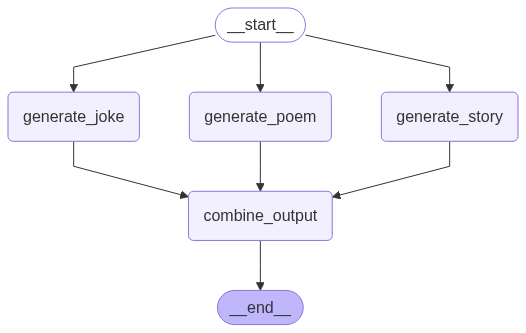

In [31]:
from IPython.display import Image
# Show workflow
display(Image(graph.get_graph().draw_mermaid_png()))


In [32]:
# Run the graph
response = graph.invoke(
    {
        "messages": [
            {"role": "user", "content": "What is the meaning of life?"}
        ]
    }
)


In [33]:
response

{'messages': [HumanMessage(content='What is the meaning of life?', additional_kwargs={}, response_metadata={}, id='b01eecf1-784f-4066-a7d5-ce111dfb3d41')],
 'joke': "The meaning of life is a question that has puzzled philosophers, scientists, and thinkers for centuries. While there isn't a definitive answer, many suggest it involves seeking happiness, forming connections, and making a positive impact. \n\nBut if you're looking for a lighthearted take, here’s a joke:\n\nWhy did the scarecrow win an award? \n\nBecause he was outstanding in his field! \n\nSo maybe a part of the meaning of life is to be extraordinary in your own unique way!",
 'poem': "The meaning of life is a complex and deeply personal question that varies for each individual. Many people find meaning through connections with others, personal fulfillment, creativity, and contributing to the greater good. Some seek purpose in spiritual beliefs, philosophical exploration, or the pursuit of knowledge. Ultimately, it’s about

### Workflow: Orchestrator-workers
With orchestrator-worker, an orchestrator breaks down a task and delegates each sub-task to workers.

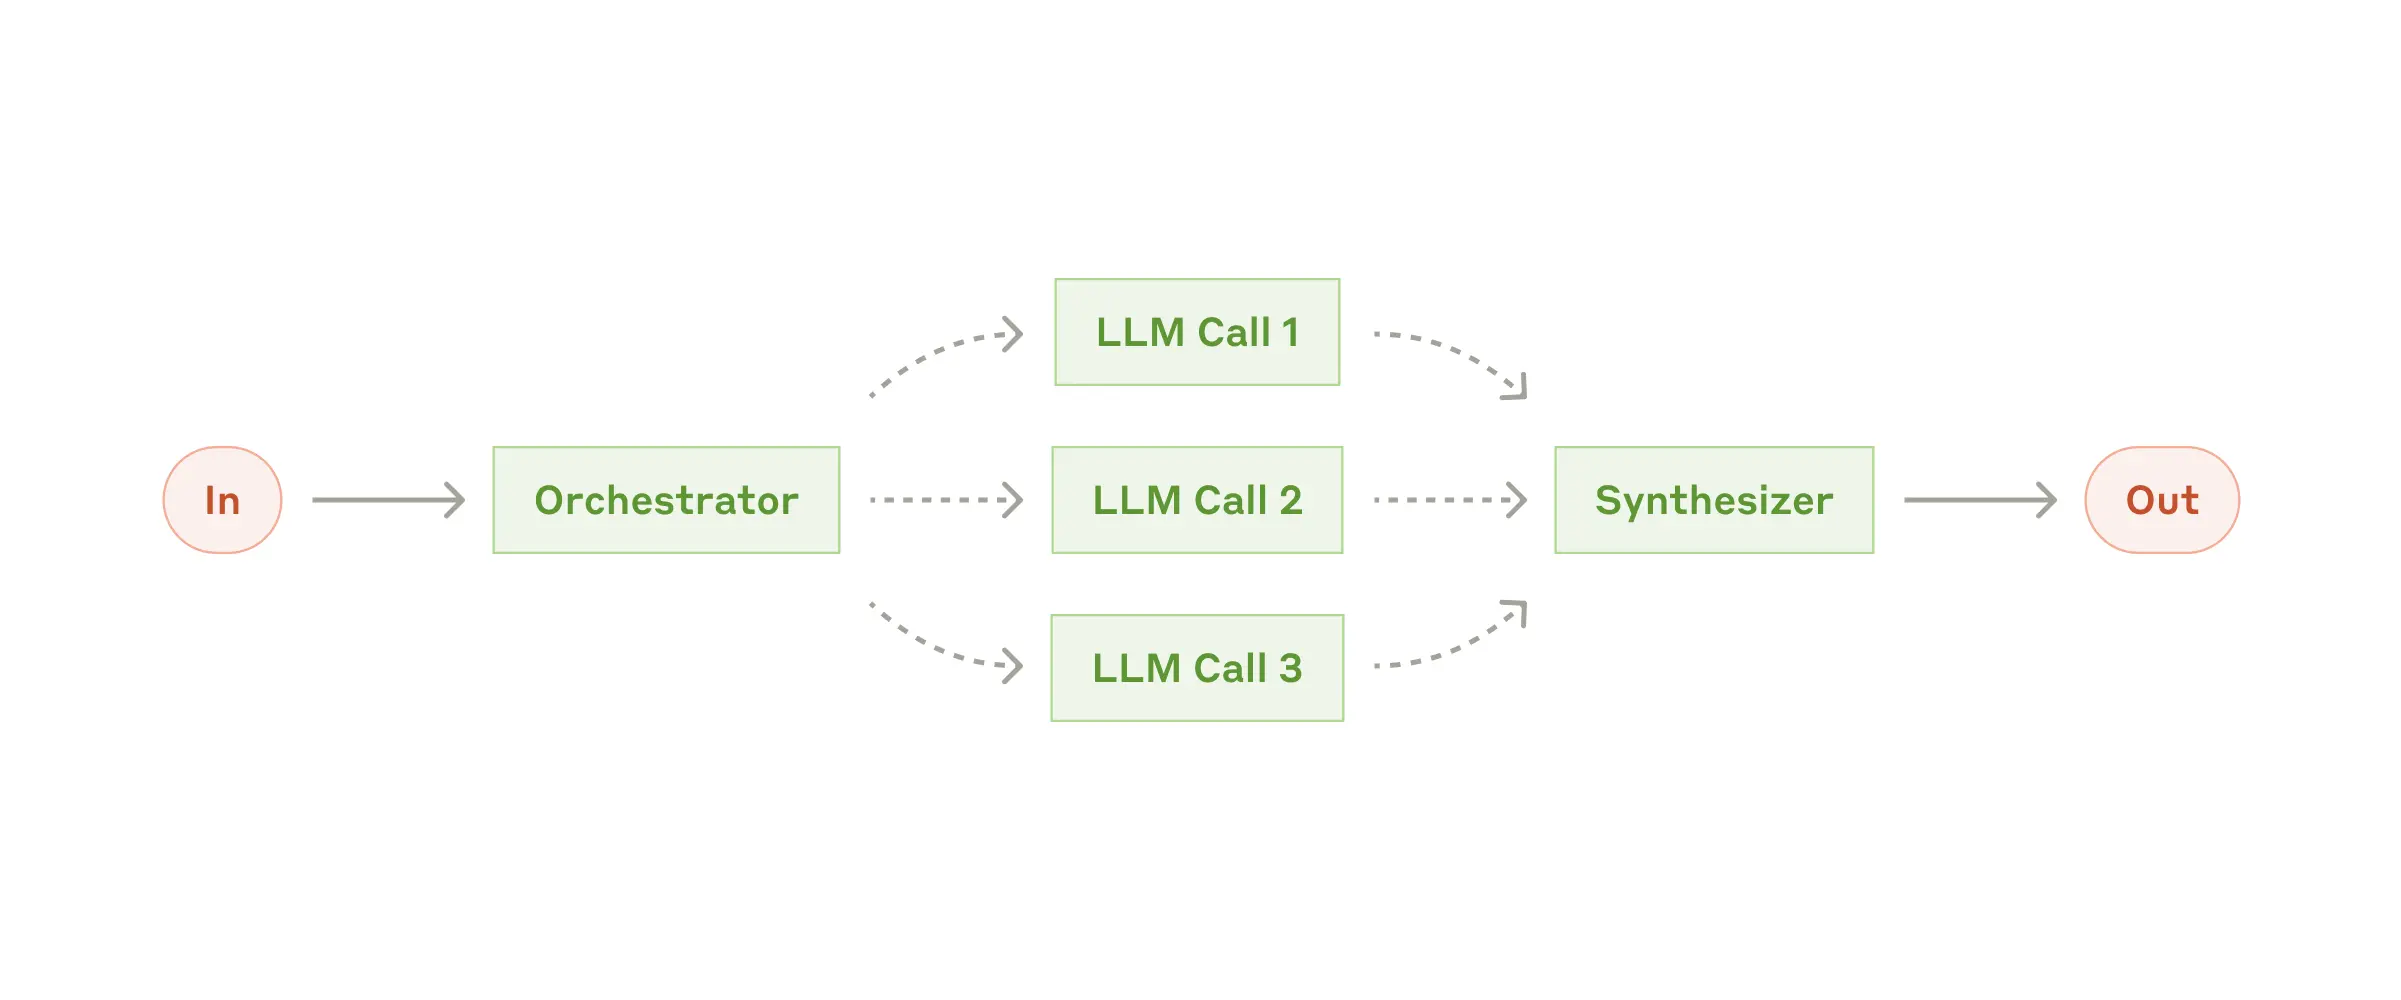

### When to use this workflow:
This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

### Example where orchestrator-workers is useful:
Coding products that make complex changes to multiple files each time.


### Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node.

### Example where orchestrator-workers:


In [34]:
from pydantic import BaseModel, Field
from typing import List
from langchain.chat_models import init_chat_model
import operator
from typing_extensions import Annotated
from langgraph.types import Send
from langgraph.graph.message import MessagesState
from langgraph.graph import StateGraph, START, END
from typing import TypedDict


llm = init_chat_model("openai:gpt-4o-mini")

#Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(description="The name of the section of the report")
    description: str = Field(description="Brief overview of the main topics and concepts to be covered in this section.")
    
class Sections(BaseModel):
    sections: List[Section] = Field(description="List of sections to be covered in the report")
    
planner_llm = llm.with_structured_output(Sections)
    
    
    

# Graph state
class SharedState(MessagesState):
    sections: list[Section]
    completed_sections: Annotated[list, operator.add]
    final_report: str
    
#Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]
    
    
#Orchestrator
def orchestrator(state: SharedState):
    """Orchestrator to generate a plan for the report"""
    
    user_query = state['messages'][-1].content
    
    system_instruction = """You are a helpful assistant that can generate a plan for the report."""
    
    messages = [
        {"role": "system", "content": system_instruction},
        {"role": "user", "content": f"Here is the report topic {user_query}. Please generate a plan for the report."}
    ]
    
    response = planner_llm.invoke(messages)
    
    return {"sections": response.sections}
    
    
#Worker
def worker(state: WorkerState):
    """Worker to write a section of the report"""
    
    section_name = state['section'].name
    section_description = state['section'].description
    
    system_instruction = """Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."""
    
    messages = [
        {"role": "system", "content": system_instruction},
        {"role": "user", "content": f"Here is the section name {section_name} and description {section_description}. Please write a report section following the provided name and description."}
    ]
    
    response = llm.invoke(messages)
    
    return {"completed_sections": [response.content]}

def synthesizer(state: SharedState):
    """Synthesize the completed sections into a final report"""
    
    final_report = "\n\n".join(state["completed_sections"])
    
    return {"final_report": final_report}

def assign_workers(state: SharedState):
    """Assign a worker to write a section of the report"""
    
    return [Send("worker", {"section": section}) for section in state["sections"]]
    
    
graph_builder = StateGraph(SharedState)
graph_builder.add_node("orchestrator", orchestrator)
graph_builder.add_node("worker", worker)
graph_builder.add_node("synthesizer", synthesizer)

graph_builder.add_edge(START, "orchestrator")
graph_builder.add_conditional_edges("orchestrator", assign_workers, ["worker"])

graph_builder.add_edge("worker", "synthesizer")
graph_builder.add_edge("synthesizer", END)
graph = graph_builder.compile()

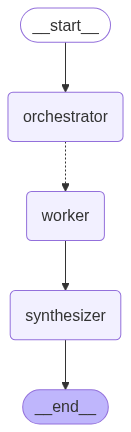

In [35]:
from IPython.display import Image
# Show workflow
display(Image(graph.get_graph().draw_mermaid_png()))


In [36]:
response = graph.invoke({"messages": [{"role": "user", "content": "Write a report about AI"}]})

In [37]:
response

{'messages': [HumanMessage(content='Write a report about AI', additional_kwargs={}, response_metadata={}, id='f9ad14da-dbb8-4e57-83fc-e7d93605bea6')],
 'sections': [Section(name='Introduction to Artificial Intelligence', description='Overview of what AI is, its history, and significance in the modern world.'),
  Section(name='Types of Artificial Intelligence', description='Discussion on various types of AI including Narrow AI, General AI, and Superintelligence along with their characteristics.'),
  Section(name='Applications of AI', description='Analysis of current applications of AI across different industries such as healthcare, finance, transportation, and entertainment.'),
  Section(name='AI Technologies and Techniques', description='Description of key technologies and techniques in AI including machine learning, deep learning, natural language processing, and computer vision.'),
  Section(name='Ethical Considerations in AI', description='Exploration of the ethical implications of 

# Workflow: Evaluator-optimizer
In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop:

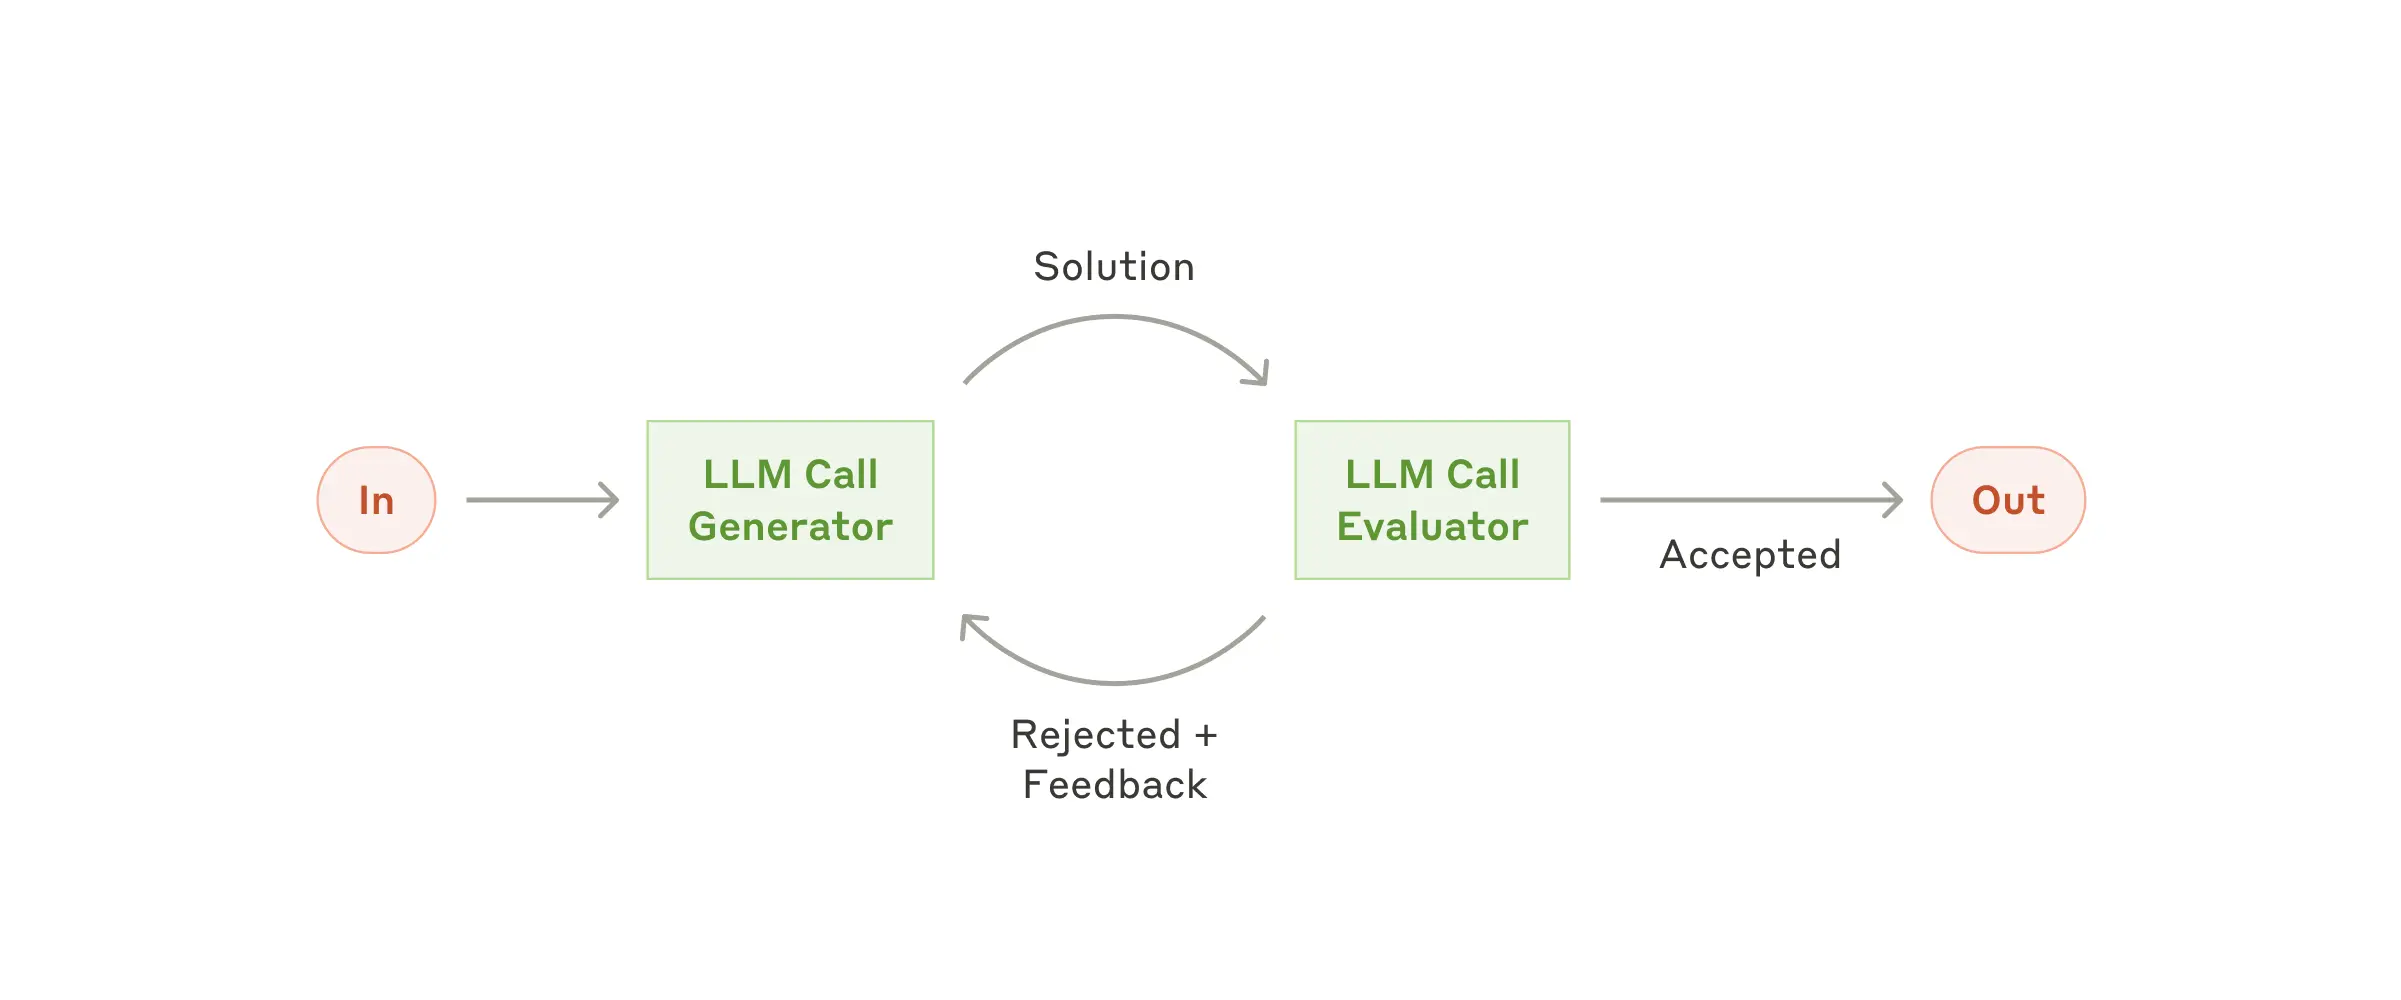


### When to use this workflow:
This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, 
- first, that LLM responses can be demonstrably improved when a human articulates their feedback; 
- and second, that the LLM can provide such feedback. 

This is similar to the iterative writing process a human writer might go through when producing a polished document.

### Examples where evaluator-optimizer is useful:
- Complex search tasks that require multiple rounds of searching and analysis to gather comprehensive information, where the evaluator decides whether further searches are warranted.


In [38]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState
from pydantic import BaseModel, Field
from typing import TypedDict, Literal
from langchain.chat_models import init_chat_model


llm = init_chat_model("openai:gpt-4o-mini")


# Define the state
class AgentState(TypedDict):
    """State for the agent"""
    customer_email: str
    draft_reply: str
    final_reply: str
    quality: Literal["pass", "fail"]
    feedback: str


# Define the AnalyzedInput class
class EmailReplyFeedback(BaseModel):
    quality: Literal["pass", "fail"] = Field(
        description="Mark as 'pass' if the reply is helpful, complete, professional, and appropriately toned. Otherwise, mark as 'fail'."
    )
    feedback: str = Field(
        description=(
            "If marked 'fail', provide detailed, actionable feedback. "
            "Mention missing information, tone issues, or anything unclear or unhelpful. "
            "Ensure feedback focuses on tone, completeness, and clarity."
        )
    )

    
evaluator_llm = llm.with_structured_output(EmailReplyFeedback)

#Generate email node
def generate_reply_email(state: AgentState):
    """Generate an email reply"""
    
    customer_email = state['customer_email']
    
    feedback = state.get("feedback", "")
    
    if feedback:
        feedback = f"Here is some feedback {feedback}."
    else:
        feedback = ""
    
    system_instruction = """You are a helpful assistant that can a very simple email reply."""
    messages = [
        {"role": "system", "content": system_instruction},
        {"role": "user", "content": f"Here is the customer email {customer_email}. {feedback}"}
    ]
    response = llm.invoke(messages)
    
    return {"draft_reply": response.content}


def evaluate_reply(state: AgentState):
    """Evaluate the email reply"""
    
    customer_email = state['customer_email']
    
    draft_reply = state['draft_reply']
    
    system_instruction = """You are a helpful assistant that can evaluate an email reply."""
    
    messages = [
        {"role": "system", "content": system_instruction},
        {"role": "user", "content": f"Here is the draft reply {draft_reply} and the actual email {customer_email}. Please evaluate the email reply."}
    ]
    response = evaluator_llm.invoke(messages)
    
    return {"quality": response.quality, "feedback": response.feedback}


def router_by_quality(state: AgentState):
    """Router by quality"""
    
    if state['quality'] == "pass":
        return "Accepted"
    
    return "Rejected"


graph_builder = StateGraph(AgentState)
graph_builder.add_node("generate_reply_email", generate_reply_email)
graph_builder.add_node("evaluate_reply", evaluate_reply)


graph_builder.add_edge(START, "generate_reply_email")
graph_builder.add_edge("generate_reply_email", "evaluate_reply")
graph_builder.add_conditional_edges("evaluate_reply", router_by_quality, {"Accepted": END, "Rejected": "generate_reply_email"})

graph = graph_builder.compile()


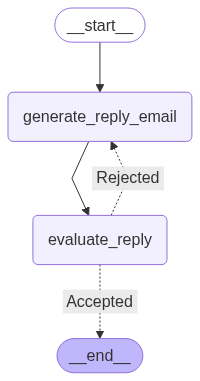

In [39]:
from IPython.display import Image
# Show workflow
display(Image(graph.get_graph().draw_mermaid_png()))


In [40]:
response = graph.invoke({"customer_email": """ Subject: Order Issue – Wrong Item Delivered

Hi,

I recently ordered a Bluetooth speaker (Order #45678), but instead I received a pair of headphones.

I double-checked the order confirmation, and it clearly says Bluetooth speaker. I’d like to get the correct item as soon as possible.

Can you help fix this? Also, do I need to return the headphones?

Thanks,

James Mwangi
"""})

In [41]:
response

{'customer_email': ' Subject: Order Issue – Wrong Item Delivered\n\nHi,\n\nI recently ordered a Bluetooth speaker (Order #45678), but instead I received a pair of headphones.\n\nI double-checked the order confirmation, and it clearly says Bluetooth speaker. I’d like to get the correct item as soon as possible.\n\nCan you help fix this? Also, do I need to return the headphones?\n\nThanks,\n\nJames Mwangi\n',
 'draft_reply': 'Subject: Re: Order Issue – Wrong Item Delivered\n\nHi James,\n\nThank you for reaching out. I’m sorry to hear about the mix-up with your order. We will certainly help you get the correct Bluetooth speaker.\n\nPlease return the headphones, and we’ll provide you with a return label. Once we receive the headphones, we’ll ship out the Bluetooth speaker right away.\n\nIf you have any further questions, feel free to ask!\n\nBest,  \n[Your Name]  \n[Your Position]  \n[Your Company]',
 'quality': 'pass',
 'feedback': ''}

# Agents
Agents are typically implemented as an LLM performing actions (via tool-calling) based on environmental feedback in a loop.

Agents can handle sophisticated tasks, but their implementation is often straightforward. 
They are typically just LLMs using tools based on environmental feedback in a loop. 
It is therefore crucial to design 
- toolsets and 
- their documentation clearly and thoughtfully.

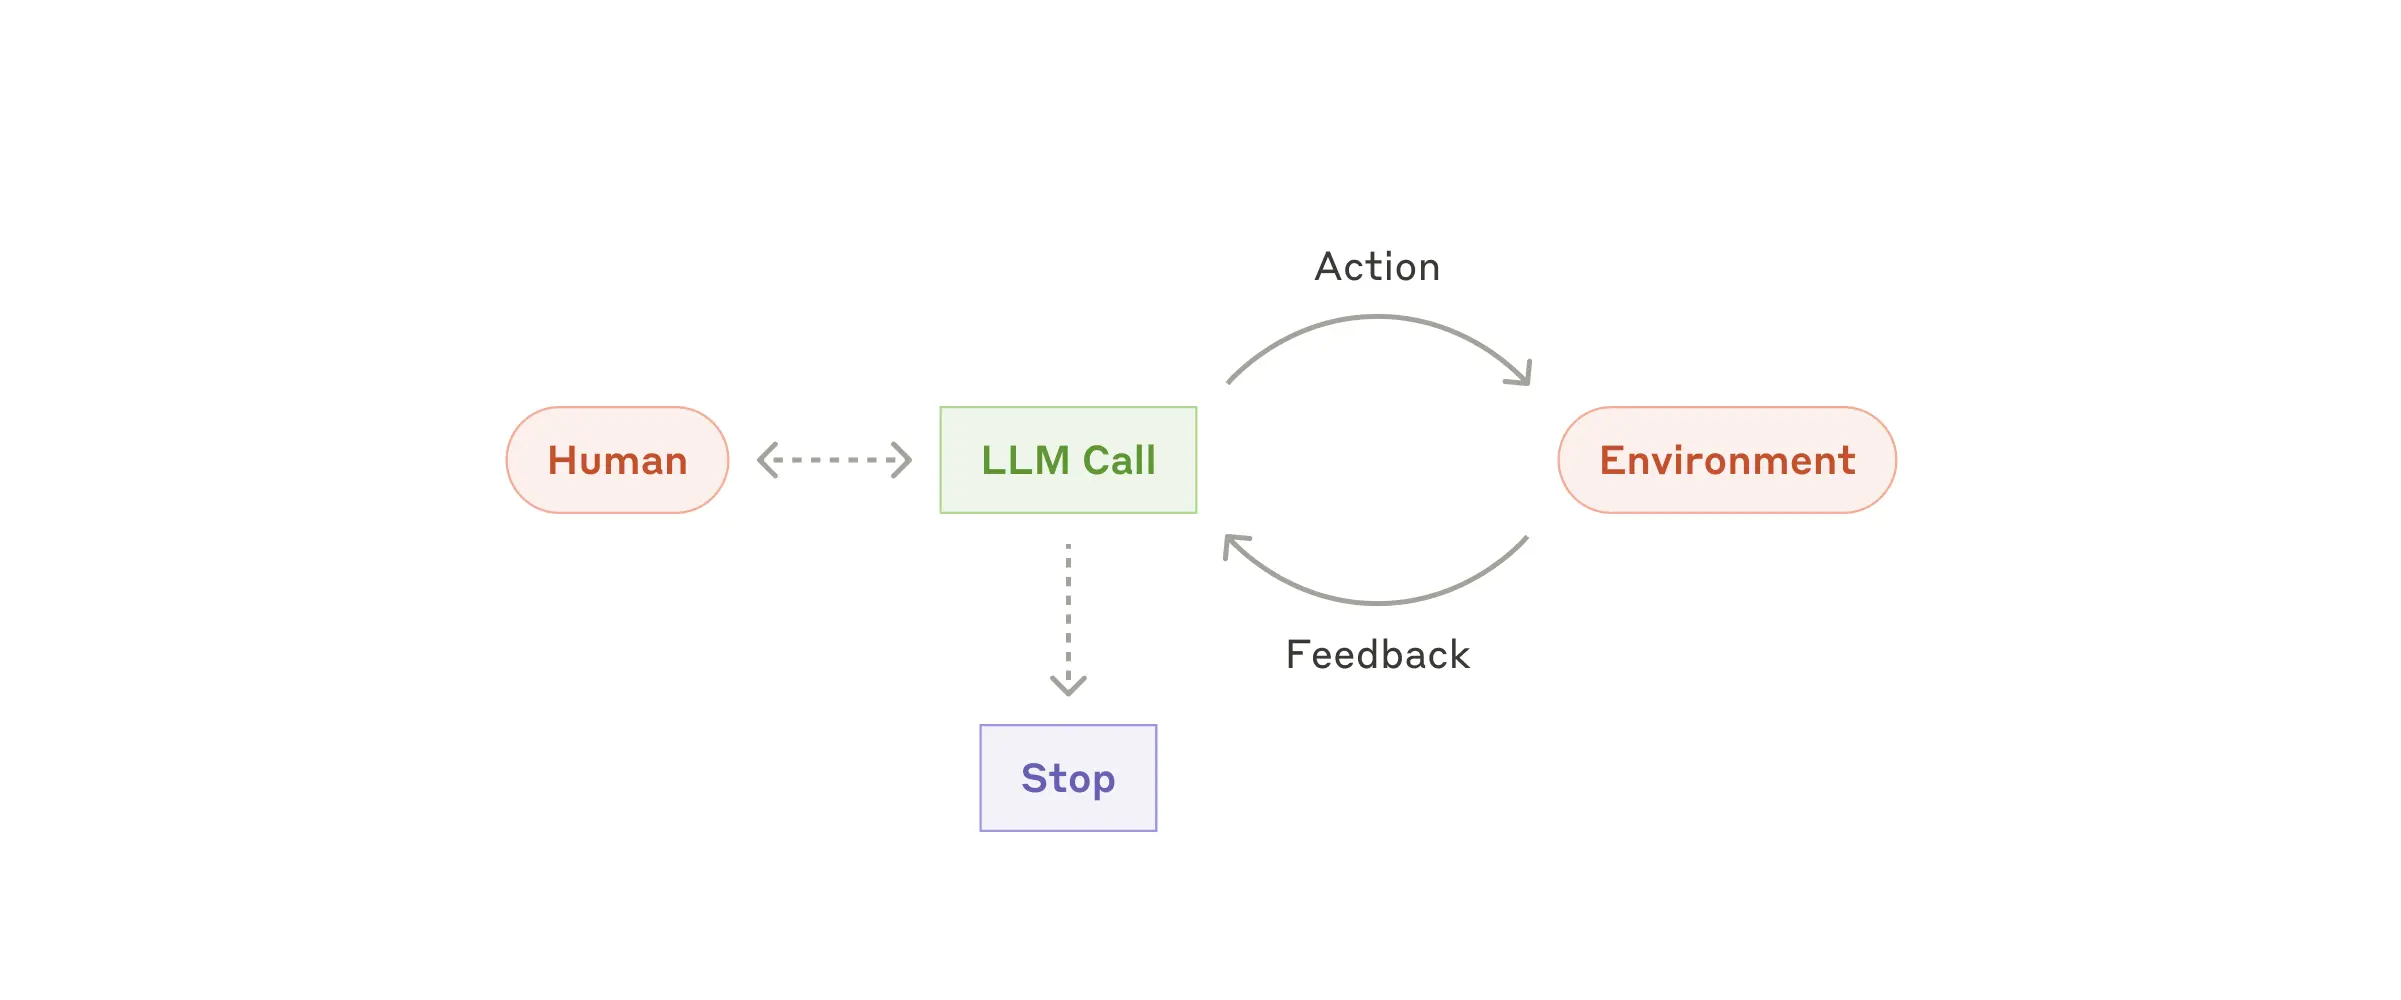


### When to use agents:
Agents can be used for open-ended problems where it’s difficult or impossible to predict the required number of steps, and where you can’t hardcode a fixed path. 
The LLM will potentially operate for many turns, and you must have some level of trust in its decision-making. 
Agents' autonomy makes them ideal for scaling tasks in trusted environments.

The autonomous nature of agents means:
 - higher costs, 
 - and the potential for compounding errors. 
 
It is therefore recommended to perform extensive testing in sand boxed environments, along with the appropriate guardrails.


### Examples where agents are useful:
- A coding Agent, which involve edits to many files based on a task description;

In [42]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState
from pydantic import BaseModel, Field
from typing import TypedDict, Literal
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage

llm = init_chat_model("openai:gpt-4o-mini")


# Define the state
class AgentState(MessagesState):
    """State for the agent"""
    
    
#Define tools
@tool
def get_product_price(product_name: str) -> str:
    """Get the product price"""
    return f"The price of {product_name} is $10."

@tool
def get_weather_info(city: str) -> str:
    """Get the weather info"""
    return f"The weather in {city} is sunny."

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def divide(a: int, b: int) -> int:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b


@tool
def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b
    
    
tools = [get_product_price, get_weather_info, multiply, divide, add]

tools_by_name = {tool.name: tool for tool in tools}

llm_with_tools = llm.bind_tools(tools)


def llm_call(state: AgentState):
    """LLM call"""
    
    messages = state['messages']
    
    system_instruction = """You are a helpful assistant tasked with performing arithmetic on a set of inputs."""
    
    messages = [
        {"role": "system", "content": system_instruction}
    ] + messages
    
    response = llm_with_tools.invoke(messages)
    
    return {"messages": [response]}


def tool_node(state: AgentState):
    """Tool node"""
    
    result = []
    
    for tool_call in state['messages'][-1].tool_calls:
        tool = tools_by_name[tool_call['name']]
        
        observation = tool.invoke(tool_call['args'])
        
        result.append(ToolMessage(content=observation, tool_call_id=tool_call['id']))
        
    return {"messages": result}


def should_continue(state: AgentState)->Literal["tool_node", END]:
    """Should continue"""
    
    messages = state['messages']
    
    last_message = messages[-1]
    
    if last_message.tool_calls:
        return "tool_node"
    
    return END
        
        
agent_builder = StateGraph(AgentState)

agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges("llm_call", should_continue, {"tool_node": "tool_node", END: END})
agent_builder.add_edge("tool_node", "llm_call")

graph = agent_builder.compile()

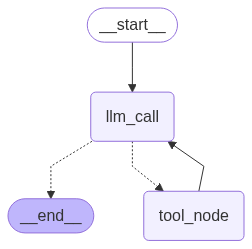

In [43]:
from IPython.display import Image
# Show workflow
display(Image(graph.get_graph().draw_mermaid_png()))


In [44]:
response = graph.invoke(
    {
        "messages": [
            {"role": "user", "content": "What is the price of a m4?"}
        ]
    }
)

In [45]:
response

{'messages': [HumanMessage(content='What is the price of a m4?', additional_kwargs={}, response_metadata={}, id='a5a0962d-a76e-4f6f-91f9-788c1b5449a3'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_m70lWD95RjV3dTdKCcZKdKlH', 'function': {'arguments': '{"product_name":"m4"}', 'name': 'get_product_price'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 193, 'total_tokens': 210, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-C1VAkjxVffyowrVXWCHtD1o0VrM1J', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--796b2927-f552-4591-8af6-c7f201aec6dd-0', tool_calls=[{'name': 'get_product_price', 'args': {'product_name'